In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import cProfile, pstats
import random
import os
import io
import re

from matplotlib.lines import Line2D
from PIL import Image

sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.set_option('display.max_columns', 30)
random.seed(0)
np.random.seed(0)

In [98]:
def add_pstats(df_):
    dframe = df_.copy()
    data = {
        'boxify_ncalls': [], 
        'boxify_tottime': [], 
        'boxify_cumtime': [],
        'is_free_ncalls': [], 
        'is_free_tottime': [], 
        'is_free_cumtime': [],
        'count_ncalls': [], 
        'count_tottime': [], 
        'count_cumtime': [],
    }
    for i in range(dframe.shape[0]):
        s = io.StringIO()
        pstats.Stats(dframe['profile_path'].iloc[i], stream=s).print_stats()
        text = s.getvalue()

        splitted = text.split('\n')
        columns = re.sub(' +', ' ', splitted[6]).split()
        splitted_lines = list(map(lambda x: re.sub(' +', ' ', x).split(), splitted[7:]))
        for sl in splitted_lines:
            if 'boxify' in ''.join(sl):
                data['boxify_ncalls'].append(int(sl[0]))
                data['boxify_tottime'].append(float(sl[1]))
                data['boxify_cumtime'].append(float(sl[3]))
            if 'boxify' in ''.join(sl):
                data['is_free_ncalls'].append(int(sl[0]))
                data['is_free_tottime'].append(float(sl[1]))
                data['is_free_cumtime'].append(float(sl[3]))
            if 'count' in ''.join(sl):
                data['count_ncalls'].append(int(sl[0]))
                data['count_tottime'].append(float(sl[1]))
                data['count_cumtime'].append(float(sl[3]))
    return dframe.join(pd.DataFrame(data))

def scatter(x, y, data, hue=None, jiggle=False, alpha=1, ax=None):
    dframe = data.copy()
    hue = df[x].copy()
    if jiggle:
        std = (dframe[x].max() - dframe[x].min()) * 0.005
        dframe[x] = dframe[x] + np.random.normal(0, std, size=dframe.shape[0])
    ax = sns.scatterplot(x=x, 
                        y=y,
                        hue=hue,
                        palette='deep',
                        alpha=alpha,
                        data=dframe,
                        ax=ax)
    handles, labels  =  ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower right')
    
def box_and_bar(x, y, data):
    dframe = data.copy()
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(20)
    f.set_figheight(10)
    new_y = y + '_mean'
    to_bar = dframe[[x, y]].groupby(x).mean().rename(columns={y: new_y})
    _ = sns.boxplot(x=x, y=y, data=dframe, ax=ax1)
    _ = sns.barplot(x=to_bar.index, y=new_y, data=to_bar, ax=ax2)

In [248]:
GRID = {
    "max_edge_len": [3.0],
    "goal_rate": [0.3],
    "start_end_obstacles": [
        [1, 23], [1, 41], [1, 29], [1, 5],
        [9, 23], [9, 41], [9, 29], [9, 5],
        [19, 23], [19, 41], [19, 29], [19, 5]
    ],
    "sample_options": [1, 3, 6, 10]
}

dfs = []

for seo in GRID['start_end_obstacles']:
    for so in GRID['sample_options']:
        dr = f'results/S{seo[0]}/E{seo[1]}/SO{so}'
        files = [f for f in list(os.listdir(dr)) if f.endswith(".csv")]
        for file in files:
            df = pd.read_csv(f'{dr}/{file}')
            df['png_path'] = [f'{dr}/{file.split(".")[0]}/{i}.png' for i in range(df.shape[0])]
            df['profile_path'] = [f'{dr}/{file.split(".")[0]}/{i}' for i in range(df.shape[0])]
            df['sample_options'] = so
            df['start'] = seo[0]
            df['end'] = seo[1]
            df['start_end'] = f'{seo[0]}_{seo[1]}'
            df = add_pstats(df).drop(['profile_path', 'Unnamed: 0'], axis=1)
            dfs.append(df)
            

df = pd.concat(dfs).reset_index().drop('index', axis=1)
df

,start_x,start_y,end_x,end_y,euclidian_distance,max_edge_len,goal_rate,finished,iter_count,final_distance,time,png_path,sample_options,start,end,start_end,boxify_ncalls,boxify_tottime,boxify_cumtime,is_free_ncalls,is_free_tottime,is_free_cumtime,count_ncalls,count_tottime,count_cumtime
0,14.0,2.5,22.0,20.5,19.697716,3.0,0.3,False,NaN,NaN,0.161582,results/S1/E23/SO6/result_1_H/0.png,6,1,23,1_23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.0,2.5,35.5,43.0,45.853026,3.0,0.3,False,NaN,NaN,0.133987,results/S1/E41/SO6/result_1_b/0.png,6,1,41,1_41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.0,2.5,43.0,20.5,34.132096,3.0,0.3,False,NaN,NaN,0.132988,results/S1/E29/SO6/result_1_o/0.png,6,1,29,1_29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.0,2.5,35.0,2.5,21.000000,3.0,0.3,False,NaN,NaN,0.135079,results/S1/E5/SO6/result_1_l/0.png,6,1,5,1_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47.0,2.5,22.0,20.5,30.805844,3.0,0.3,False,NaN,NaN,0.162348,results/S9/E23/SO6/result_1_M/0.png,6,9,23,9_23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,47.0,2.5,35.5,43.0,42.101069,3.0,0.3,False,NaN,NaN,0.134063,results/S9/E41/SO6/result_1_J/0.png,6,9,41,9_41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,47.0,2.5,43.0,20.5,18.439089,3.0,0.3,False,NaN,NaN,0.132335,results/S9/E29/SO6/result_1_U/0.png,6,9,29,9_29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,47.0,2.5,32.0,2.5,15.000000,3.0,0.3,False,NaN,NaN,0.132650,results/S9/E5/SO6/result_1_e/0.png,6,9,5,9_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,46.0,14.5,22.0,20.5,24.738634,3.0,0.3,False,NaN,NaN,0.129314,results/S19/E23/SO6/result_1_v/0.png,6,19,23,19_23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,46.0,14.5,35.5,43.0,30.372685,3.0,0.3,False,NaN,NaN,0.134045,results/S19/E41/SO6/result_1_b/0.png,6,19,41,19_41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Sample options

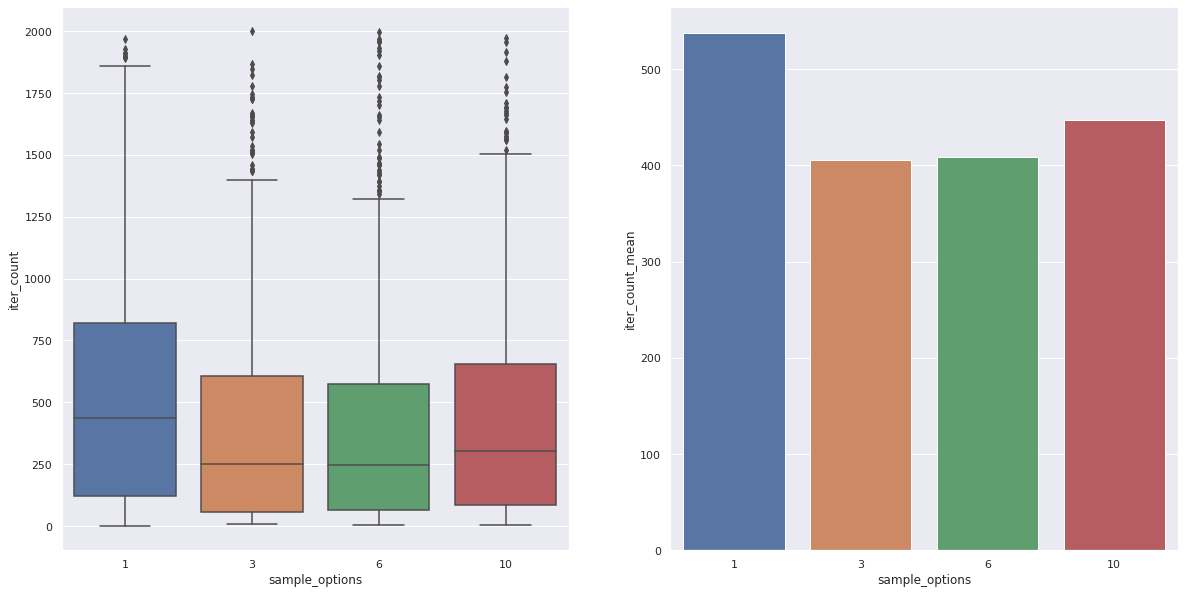

In [99]:
box_and_bar('sample_options', 'iter_count', df)

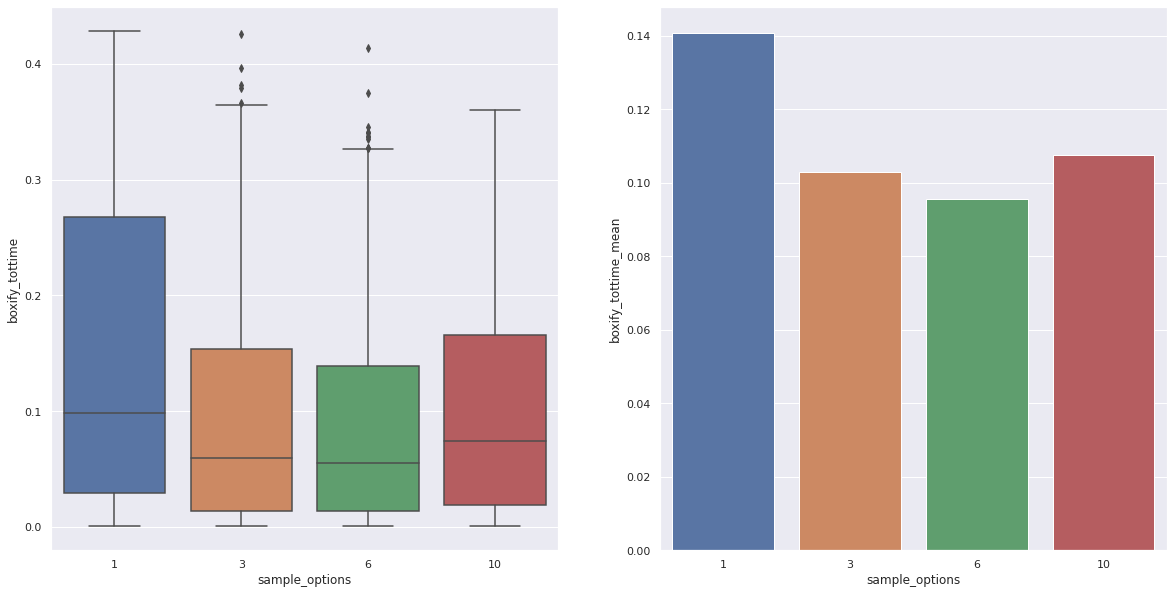

In [100]:
box_and_bar('sample_options', 'boxify_tottime', df)

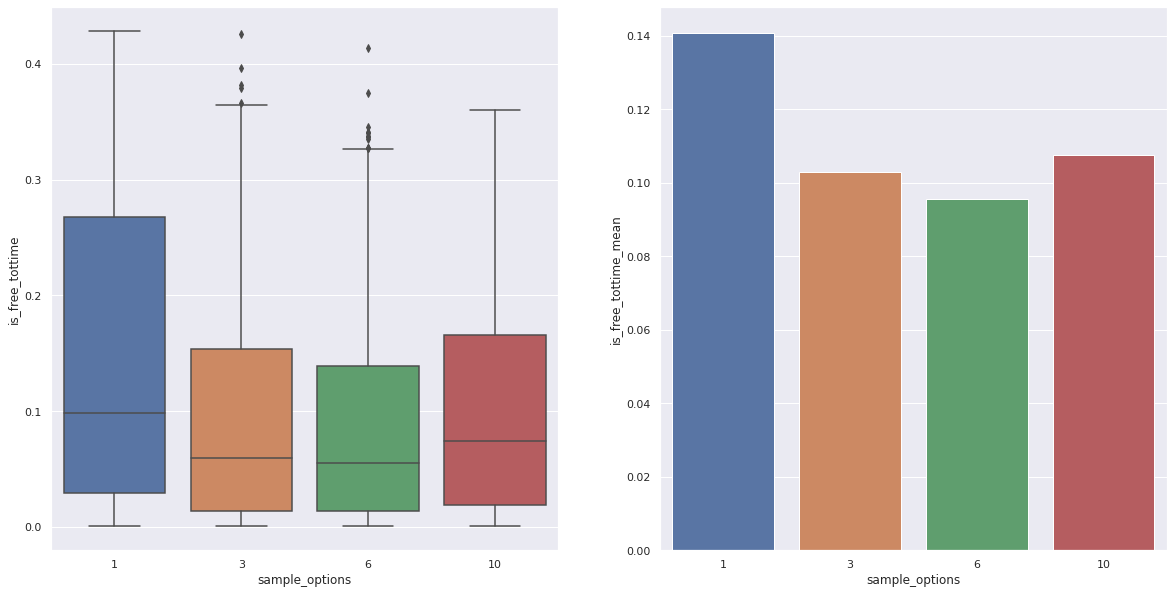

In [101]:
box_and_bar('sample_options', 'is_free_tottime', df)

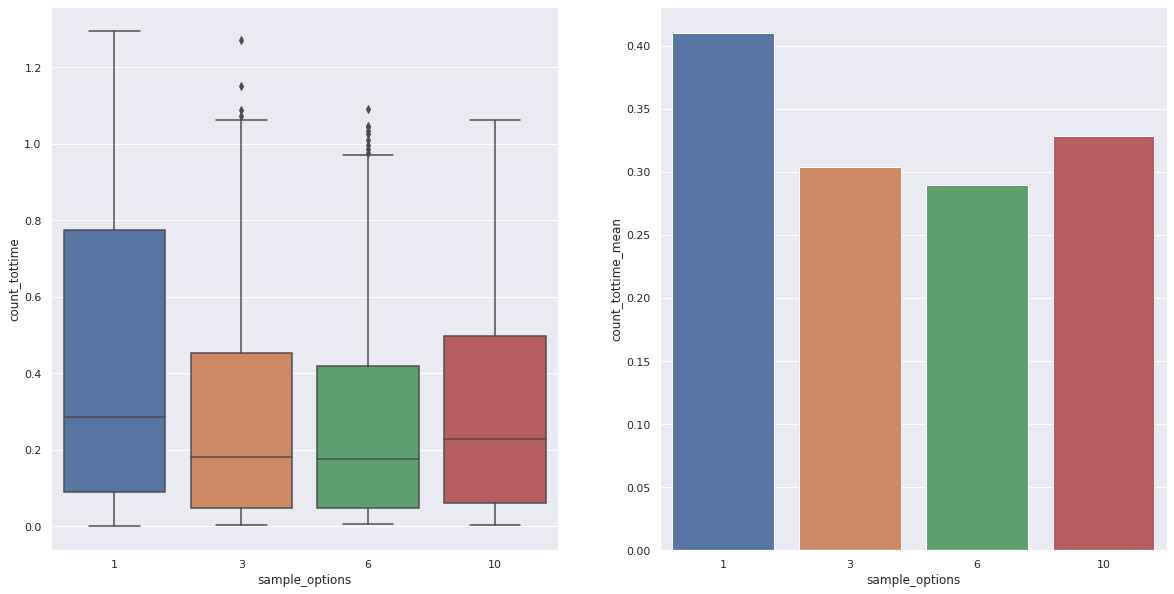

In [102]:
box_and_bar('sample_options', 'count_tottime', df)

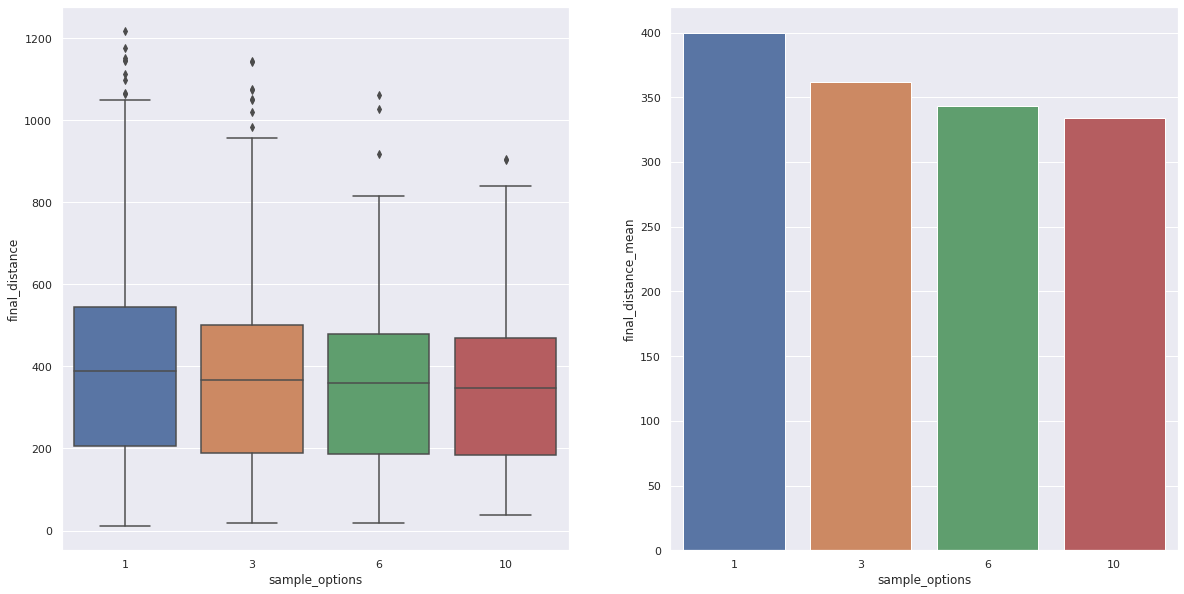

In [103]:
box_and_bar('sample_options', 'final_distance', df)

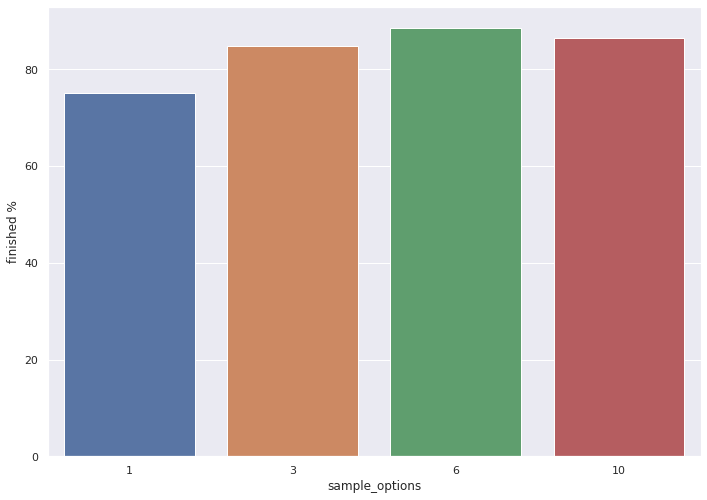

In [69]:
so_finished = df[['sample_options', 'finished']].groupby('sample_options').mean().rename(columns={'finished':'finished %'})
so_finished['finished %'] *= 100
_ = sns.barplot(x=so_finished.index, y=so_finished['finished %'])

# Start and finish points configurations

In [224]:
df6 = df[df['sample_options'] == 6].copy()
df6

,start_x,start_y,end_x,end_y,euclidian_distance,max_edge_len,goal_rate,finished,iter_count,final_distance,time,png_path,sample_options,start,end,start_end,boxify_ncalls,boxify_tottime,boxify_cumtime,is_free_ncalls,is_free_tottime,is_free_cumtime,count_ncalls,count_tottime,count_cumtime
120,14.0,2.5,22.0,20.5,19.697716,3.0,0.3,True,336.0,538.119938,3.747141,results/S1/E23/SO6/result_15_Kclp/0.png,6,1,23,1_23,25070,0.063,2.033,25070,0.063,2.033,23473,0.211,0.546
121,14.0,2.5,22.0,20.5,19.697716,3.0,0.3,True,1212.0,518.797501,14.305938,results/S1/E23/SO6/result_15_Kclp/1.png,6,1,23,1_23,96871,0.246,7.829,96871,0.246,7.829,90945,0.674,1.953
122,14.0,2.5,22.0,20.5,19.697716,3.0,0.3,False,NaN,NaN,30.702322,results/S1/E23/SO6/result_15_Kclp/2.png,6,1,23,1_23,127480,0.326,10.322,127480,0.326,10.322,119857,0.954,2.650
123,14.0,2.5,22.0,20.5,19.697716,3.0,0.3,True,457.0,417.869431,4.574026,results/S1/E23/SO6/result_15_Kclp/3.png,6,1,23,1_23,30424,0.077,2.470,30424,0.077,2.470,28542,0.241,0.642
124,14.0,2.5,22.0,20.5,19.697716,3.0,0.3,True,1049.0,377.761863,11.418285,results/S1/E23/SO6/result_15_Kclp/4.png,6,1,23,1_23,79022,0.197,6.323,79022,0.197,6.323,74134,0.572,1.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,46.0,14.5,32.0,2.5,18.439089,3.0,0.3,True,38.0,144.721349,0.614074,results/S19/E5/SO6/result_15_ISrK/10.png,6,19,5,19_5,3618,0.009,0.273,3618,0.009,0.273,3393,0.029,0.072
2816,46.0,14.5,32.0,2.5,18.439089,3.0,0.3,True,65.0,138.055743,0.853021,results/S19/E5/SO6/result_15_ISrK/11.png,6,19,5,19_5,5453,0.013,0.409,5453,0.013,0.409,5101,0.043,0.109
2817,46.0,14.5,32.0,2.5,18.439089,3.0,0.3,True,44.0,194.711664,0.596651,results/S19/E5/SO6/result_15_ISrK/12.png,6,19,5,19_5,3492,0.008,0.263,3492,0.008,0.263,3283,0.028,0.070
2818,46.0,14.5,32.0,2.5,18.439089,3.0,0.3,True,49.0,75.219438,0.734373,results/S19/E5/SO6/result_15_ISrK/13.png,6,19,5,19_5,4129,0.010,0.312,4129,0.010,0.312,3862,0.033,0.083


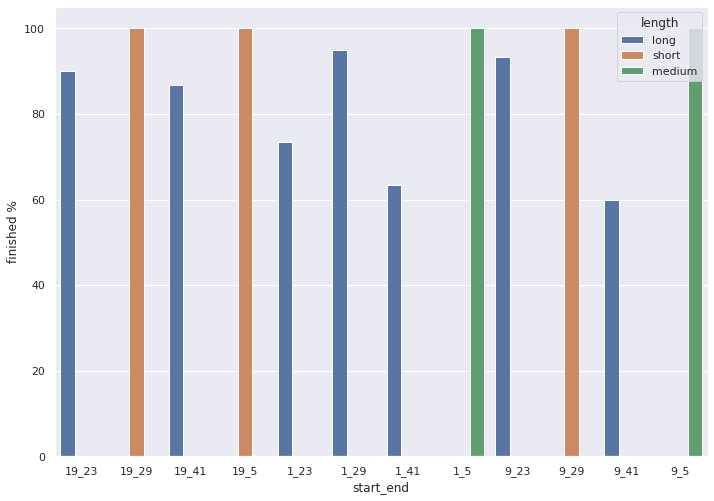

In [239]:
def dist_to_str(d):
    if d <= 200:
        return 'short'
    elif d <= 300:
        return 'medium'
    else:
        return 'long'

to_bar = df6.groupby(['start_end']).mean().reset_index()
to_bar['finished'] *= 100
to_bar = to_bar.rename(columns={'finished': 'finished %'})
to_bar['length'] = to_bar['final_distance'].apply(lambda x: dist_to_str(x))
_ = sns.barplot(x='start_end', y='finished %', hue='length', data=to_bar)

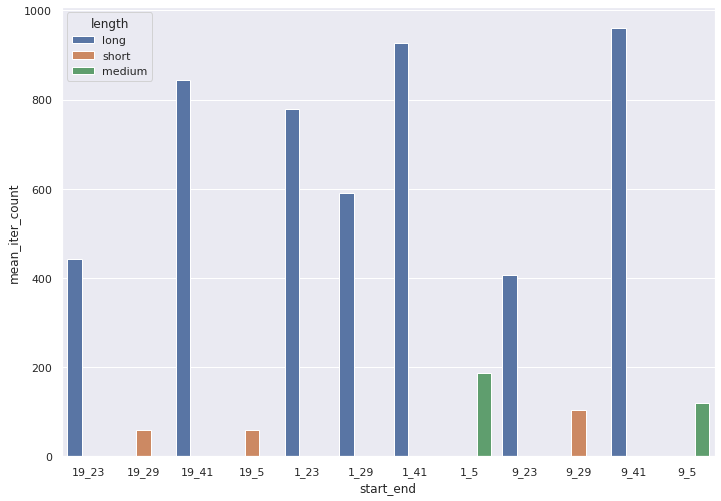

In [242]:
to_bar = df6.groupby(['start_end']).mean().reset_index()
to_bar = to_bar.rename(columns={'iter_count': 'mean_iter_count'})
to_bar['length'] = to_bar['final_distance'].apply(lambda x: dist_to_str(x))
_ = sns.barplot(x='start_end', y='mean_iter_count', hue='length', data=to_bar)

In [245]:
short = ['19_29', '19_5', '9_29']
medium = ['1_5', '9_5']
long = ['19_23', '19_41', '1_23', '1_29', '1_41', '9_23', '9_41']

In [275]:
df6[df6['start_end'].isin(long)]['finished'].mean()

0.8023809523809524